## Environment Setting
Google drive mount (for Colab users) and package importing.
You can optionally work on a transformer part.

In [ ]:
# For Colab users
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.insert(0,'/content/drive/{path to project directory}')

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import json

import torch.optim as optim

%load_ext autoreload
%autoreload 2
from data_utils import MLDataset, collate_fn
from modeling import Seq2SeqModel

## (Optional) Sample Visualization
You can see actual sample images and correct answers. Additional matplotlib package is needed.

In [2]:
# Just for reference: see actual samples
import matplotlib.pyplot as plt

id_to_char = {}
alphabets = "abcdefghijklmnopqrstuvwxyz"
for i, c in enumerate(alphabets):
    id_to_char[i+1] = c

Answer: hear ([8, 5, 1, 18])
Input image sequence:


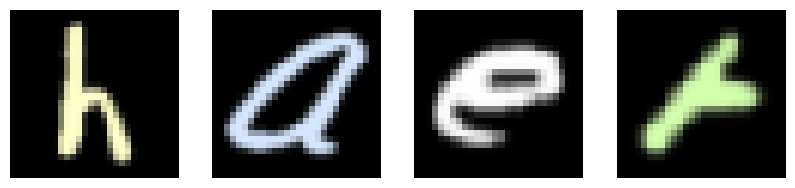

In [3]:
# Just for reference: see actual samples
idx = 1234
sample = np.load(f'./data_final/imgs/train/{idx}.npy')
with open('./data_final/labels/train.json', 'r') as f:
    sample_target = json.load(f)[str(idx)]
    
tgt_char = ""
for i in sample_target:
    tgt_char += id_to_char[i]


print(f"Answer: {tgt_char} ({sample_target})")
print("Input image sequence:")

plt.figure(figsize=(10, len(sample)))
for i, img in enumerate(sample):    
    plt.subplot(1, len(sample), i+1)
    plt.axis("off")
    plt.imshow(img)

## Device and seed setting

In [4]:
#assert torch.cuda.is_available()

# Use 0th GPU for training
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# fix random seed to increase reproducibility
# NOTE: Do not modify here!
NUM_CLASSES = 26 + 2 # 26 alphabets + 1 padding index + 1 <s> token (start token)

random_seed = 7
torch.manual_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# %env CUBLAS_WORKSPACE_CONFIG=:16:8

def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)

num_workers = 8

AttributeError: module 'torch._C' has no attribute '_cuda_setDevice'

## Model loading and training

In [5]:
# NOTE: modify path and batch size for your setting
# NOTE: you can apply custom preprocessing to the training data

BATCH_SIZE = 128

train_ds = MLDataset('data_final/imgs/train', 'data_final/labels/train.json')
valid_ds = MLDataset('data_final/imgs/valid_normal', 'data_final/labels/valid_normal.json')

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

In [8]:
# You can add or modify your Seq2SeqModel's hyperparameter (keys and values)
kwargs = {
    'hidden_dim': 64,
    'n_rnn_layers': 2,
    'rnn_dropout': 0.3,
    'device': device
}

In [9]:
NUM_CLASSES =26+2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Seq2SeqModel(num_classes=NUM_CLASSES, **kwargs).to(device)
print(model)
##############################################################################
#                          IMPLEMENT YOUR CODE                               #

# Define the optimizer and loss function
model_optim = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)  # Assuming padding index is 0

# You can define additional components like lr_scheduler, ...
lr_scheduler = optim.lr_scheduler.StepLR(model_optim, step_size=10, gamma=0.1)
# NOTE: you can define additional components like lr_scheduler, ...
##############################################################################
#                          END OF YOUR CODE                                  #
##############################################################################

Seq2SeqModel(
  (encoder): Encoder(
    (cnn): CustomCNN(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1152, out_features=64, bias=True)
    )
    (rnn): LSTM(64, 64, num_layers=2, batch_first=True)
    (fc): Linear(in_features=64, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(28, 64, padding_idx=0)
    (rnn): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.5)
    (lm_head): Linear(in_features=64, out_features=28, bias=True)
  )
)


In [10]:
# NOTE: you can freely modify or add training hyperparameters
print_interval = 1000
max_epoch = 2

In [13]:
def train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=None, save_path='./model.pt'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    # Load your states
    loaded_epoch = 0
    loaded_best_valid_loss = -1
    if load_path is not None:
        state = torch.load(load_path)
        model.load_state_dict(state["model"])
        model_optim.load_state_dict(state["optimizer"])
        loaded_epoch = state["epoch"]
        loaded_best_valid_loss = state["best_valid_loss"]
        # ...
        
    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    best_valid_loss = 1e+10 if loaded_best_valid_loss == -1 else loaded_best_valid_loss

    for epoch in np.array(list(range(max_epoch - loaded_epoch))) + loaded_epoch:
        step = 0
        train_loss = 0
        model.train()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(train_dl)):
            data = data.to(device) # (B, T, H, W, C)
            target = target.to(device) # (B, T)
            #print(target[0, :])
            
            # start tokens should be located at the first position of the decoder input
            start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
            # print(start_tokens[0])
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Problem 5: implement loss calculation and optimization part
            # You can utilize teacher-forcing strategy to this part
            model_optim.zero_grad()
            decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)  # Teacher-forcing
            #print(decoder_input[0, :])
            logits, _ = model(data, lengths, decoder_input)
            #print(logits.shape)
            loss = loss_fn(logits.view(-1, logits.size(-1)), target.view(-1))
            loss.backward()
            model_optim.step()
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            train_loss += loss.detach().cpu().item()
            step += 1
            if (batch_idx + 1) % print_interval == 0:
                print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', loss.detach().cpu().item())
                
        train_loss_avg = train_loss / (batch_idx+1)
        print(f"epoch {epoch + 1}, train loss: {train_loss_avg}")

        valid_loss = 0
        model.eval()
        for batch_idx, (data, target, lengths) in enumerate(tqdm(valid_dl)):            
            with torch.no_grad():
                data = data.to(device) # (B, T, H, W, C)
                target = target.to(device) # (B, T)
                
                # start tokens should be located at the first position of the decoder input
                start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
                ##############################################################################
                #                          IMPLEMENT YOUR CODE                               #
                ##############################################################################
                # Implement loss calculation for valid batch (same as problem 5)
                decoder_input = torch.cat([start_tokens, target[:, :-1]], dim=1)  # Teacher-forcing
                logits, _ = model(data, lengths, decoder_input)
                loss = loss_fn(logits.view(-1, logits.size(-1)), target.view(-1))
                ##############################################################################
                #                          END OF YOUR CODE                                  #
                ##############################################################################
                valid_loss += loss.cpu().item()
        valid_loss /= (batch_idx + 1)      
        if valid_loss < best_valid_loss:
            print("New best valid loss, saving model")
            ##############################################################################
            #                          IMPLEMENT YOUR CODE                               #
            ##############################################################################
            # Save your states
            state = {
                "model": model.state_dict(),
                "optimizer": model_optim.state_dict(),
                "epoch": epoch + 1,
                "best_valid_loss": best_valid_loss,
                # ...
            }
            ##############################################################################
            #                          END OF YOUR CODE                                  #
            ##############################################################################
            torch.save(state, save_path)
            best_valid_loss = valid_loss
        print('valid epoch: %d, valid loss: %.4f, best valid loss: %.4f' % (epoch + 1, valid_loss, best_valid_loss))

    return

In [14]:
load_path = None
train(model, model_optim, loss_fn, max_epoch, train_dl, valid_dl, load_path=load_path, save_path='./model.pt')

  5%|████▎                                                                             | 28/531 [00:12<03:46,  2.22it/s]


KeyboardInterrupt: 

## Model evaluation

In [54]:
kwargs_generate = {
    # you can add arguments for your model's generate function
    'max_length': 10
}

In [55]:
# Do not modify this cell!

def eval(dataloader, model_path):
    state = torch.load(model_path)
    model.load_state_dict(state["model"])
    model.eval()

    id_to_char = {}
    id_to_char[0] = "<pad>"
    id_to_char[27] = "<s>"
    alphabets = "abcdefghijklmnopqrstuvwxyz"
    for i, c in enumerate(alphabets):
        id_to_char[i+1] = c

    results = []
    labels = []    
    for batch_idx, (data, target, lengths) in enumerate(tqdm(dataloader)):       
        data = data.to(device) # (B, T, H, W, C)
        target = target.to(device) # (B, T)
        
        # start tokens should be located at the first position of the decoder input
        start_tokens = (torch.ones([target.size(0), 1]) * 27).to(torch.long).to(device)
        with torch.no_grad():
            generated_tok = model.generate(data, lengths, start_tokens, **kwargs_generate) # (B, T)
            
        for i in range(generated_tok.size(0)):
            decoded = ""
            for j in generated_tok[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            results.append(decoded)
    
            decoded = ""
            for j in target[i][:lengths[i].int()].tolist():
                decoded += id_to_char[j]
            labels.append(decoded)
        
    corrects = []
    for i in range(len(results)):
        if results[i] == labels[i]:
            corrects.append(1)
        else:
            corrects.append(0)
    print("Accuracy: %.5f" % (sum(corrects) / len(corrects)))

    return results, labels

In [58]:
# load and evaluate your model
load_path = './model.pt'
print("Evaluation with validation set")
results, labels = eval(valid_dl, load_path)

Evaluation with validation set


100%|███████████████████████████████████████████████████████████████████████████████████| 76/76 [00:10<00:00,  7.48it/s]

Accuracy: 0.00000
